# Tutorial 5: Diagnosing & Curing Overfitting – "The Regularization Toolkit"

**Course:** CSEN 342: Deep Learning  
**Topic:** Bias/Variance Tradeoff, Regularization (L2, Dropout), and Data Augmentation

## Objective
In the lecture, we learned that a model with high capacity can easily memorize training data, leading to **Overfitting** (High Variance). This results in a large gap between training accuracy and validation accuracy.

In this tutorial, we will:
1.  **Intentionally Overfit:** Train a large MLP on a very small subset of Fashion-MNIST to create a "textbook example" of high variance.
2.  **Diagnose:** Visualize the learning curves to identify the exact epoch where generalization fails.
3.  **Cure:** systematically apply regularization techniques to fix the problem:
    * **L2 Regularization (Weight Decay)**
    * **Dropout**
    * **Data Augmentation**

---

## Part 1: The Trap (Intentional Overfitting)

We will simulate a scenario where our model is too complex for the amount of data we have. We will use only **500 images** for training but keep the full 10,000 images for validation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Import utility functions
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import download_fashion_mnist

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Prepare Data (Small Training Set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

download_fashion_mnist()
full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=False, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=False, transform=transform)

# We strictly limit training data to 500 samples to force overfitting
# Fix the seed so everyone gets the same 'random' 500 images
torch.manual_seed(42)
train_subset, _ = torch.utils.data.random_split(full_trainset, [500, 59500])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(testset)}")

Using device: cuda
Training samples: 500
Validation samples: 10000


### 1.2 The Over-Complex Model
We define a deep MLP with many neurons (512 -> 256 -> 128). Without regularization, this network has enough capacity to simply memorize the 500 training images.

In [2]:
class OverfitMLP(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(OverfitMLP, self).__init__()
        self.flatten = nn.Flatten()
        # Large hidden layers
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
        # Dropout layer (will be used in Part 2)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        return self.fc4(x)

# Utility function to train and return history
def train_model(model, weight_decay=0.0, epochs=100):
    criterion = nn.CrossEntropyLoss()
    # L2 Regularization is set via the 'weight_decay' parameter in SGD
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    model.to(device)
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(trainloader))
        train_accs.append(100 * correct / total)
        
        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(testloader))
        val_accs.append(100 * correct / total)
        
    return train_losses, val_losses, train_accs, val_accs

print("Training Utility Defined.")

Training Utility Defined.


### 1.3 Baseline Run: No Regularization
Let's train the model with `weight_decay=0.0` and `dropout_rate=0.0` for **100 epochs**.

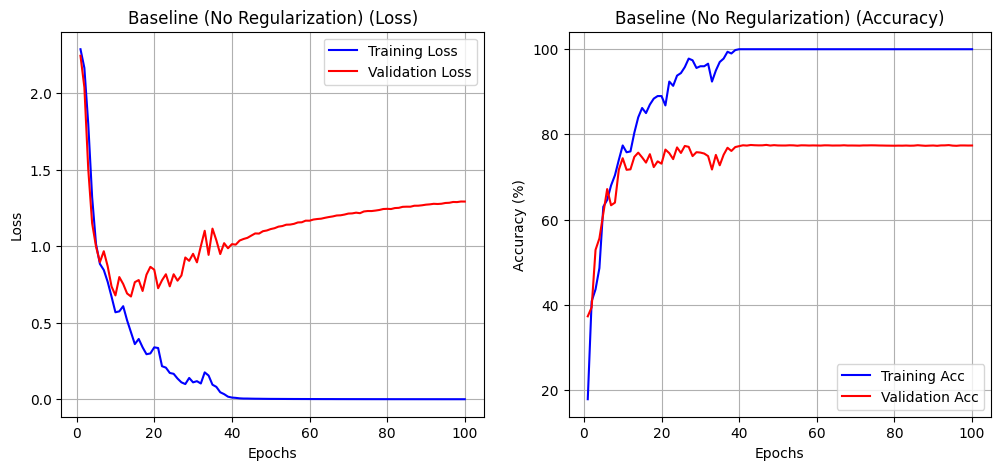

In [3]:
baseline_model = OverfitMLP(dropout_rate=0.0)
hist_base = train_model(baseline_model, weight_decay=0.0, epochs=100)

# Plotting Function
def plot_curves(history, title):
    train_loss, val_loss, train_acc, val_acc = history
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{title} (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title(f'{title} (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_curves(hist_base, "Baseline (No Regularization)")

**Discussion:** Look at the curves above. 
* **Training Accuracy** likely hits 100% (Memorization).
* **Validation Accuracy** plateaus much lower.
* **The Gap:** The large space between the red and blue lines is **Variance** (Overfitting).

---

## Part 2: The Cure (Applying Regularization)

Now we systematically apply the techniques from the lecture to close this gap.

### 2.1 Cure #1: L2 Regularization (Weight Decay)
We penalize large weights by adding $\lambda ||w||^2$ to the loss function. In PyTorch, we do this by setting the `weight_decay` parameter in the optimizer.

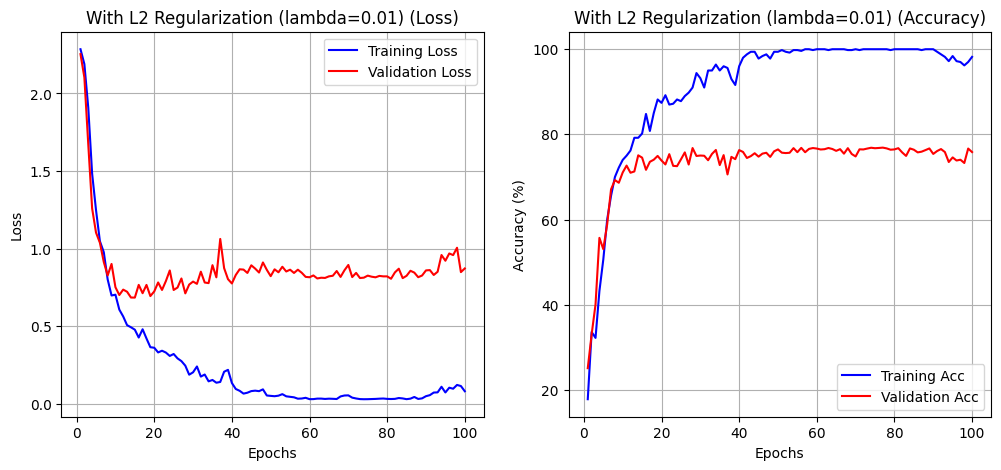

In [4]:
# We use a moderate weight decay (lambda = 0.01)
l2_model = OverfitMLP(dropout_rate=0.0)
hist_l2 = train_model(l2_model, weight_decay=0.01, epochs=100)

plot_curves(hist_l2, "With L2 Regularization (lambda=0.01)")

### 2.2 Cure #2: Dropout
We randomly "kill" neurons during training with probability $p$. This prevents neurons from co-adapting too much. 
We update our model to use `dropout_rate=0.5`.

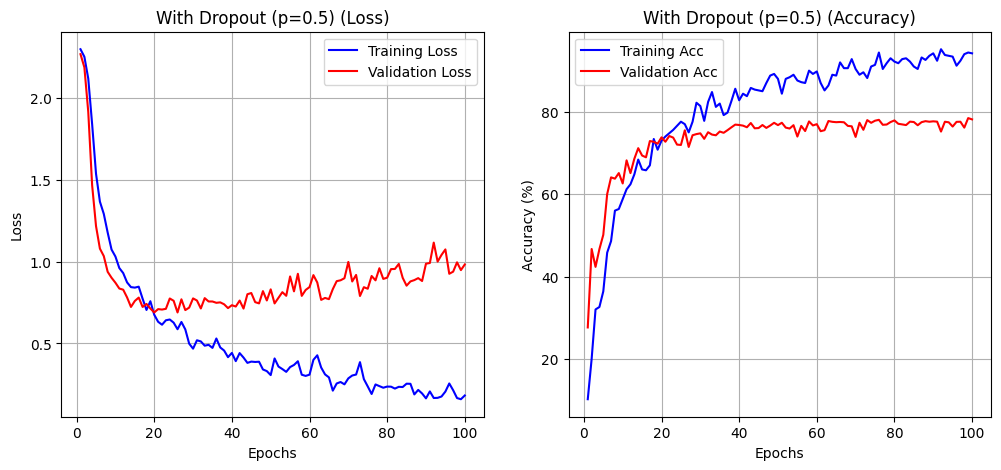

In [5]:
dropout_model = OverfitMLP(dropout_rate=0.5)
hist_drop = train_model(dropout_model, weight_decay=0.0, epochs=100)

plot_curves(hist_drop, "With Dropout (p=0.5)")

### 2.3 Cure #3: Data Augmentation
The best cure for overfitting is **more data**. If we can't collect more, we can invent it! We use `torchvision.transforms` to randomly flip and rotate our training images on the fly.

**Note:** Because we are making the task harder (generating new variations), the model may need more time to converge. We are already running 100 epochs, which should be sufficient.

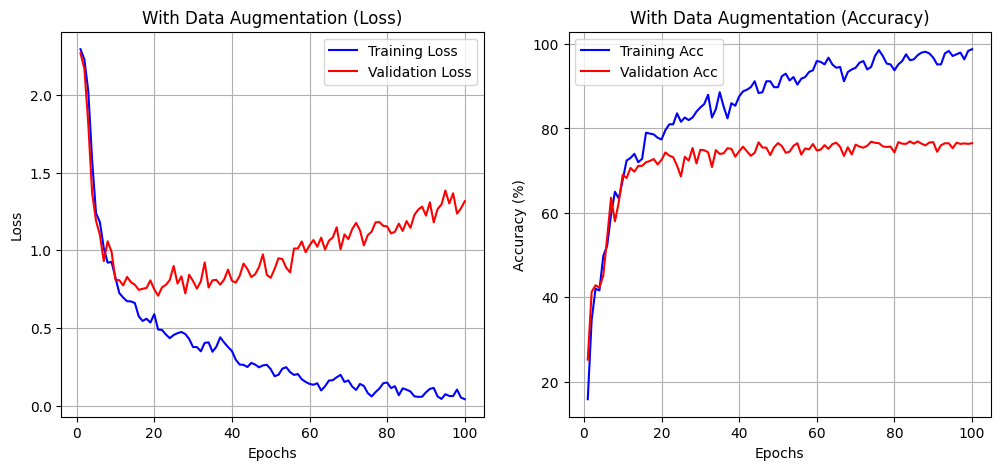

In [ ]:
# Define Augmented Transform (Gentle Random Flip + Rotation)
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Reload Training Data with Augmentation
train_subset_aug = torchvision.datasets.FashionMNIST(root='../data', train=True, download=False, transform=aug_transform)
# Note: We must use the SAME indices to keep the data count at 500 for a fair comparison
train_subset_aug = torch.utils.data.Subset(train_subset_aug, train_subset.indices)
trainloader_aug = torch.utils.data.DataLoader(train_subset_aug, batch_size=32, shuffle=True)

# We need to slightly modify our train loop to accept a custom loader, 
# or we can just swap the global variable for this cell
original_loader = trainloader
trainloader = trainloader_aug # Swap in augmented loader

aug_model = OverfitMLP(dropout_rate=0.0)
hist_aug = train_model(aug_model, weight_decay=0.0, epochs=100)

trainloader = original_loader # Restore loader

plot_curves(hist_aug, "With Data Augmentation")

---

## Part 3: Comparison

Let's check the **Generalization Gap**. 

* **High Gap (High Variance):** Model memorized the training data but failed on test data.
* **Low Gap:** Model generalized well.

We expect the Baseline to have the highest gap, and the Regularized models to have smaller gaps.

In [7]:
def print_stats(name, hist):
    train_acc = hist[2][-1]
    val_acc = hist[3][-1]
    gap = train_acc - val_acc
    print(f"{name:<15} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | GAP: {gap:.2f}%")

print("Final Results (Lower Gap = Better Generalization):")
print("-"*65)
print_stats("1. Baseline", hist_base)
print_stats("2. L2 Regular", hist_l2)
print_stats("3. Dropout", hist_drop)
print_stats("4. Augment", hist_aug)

Final Results (Lower Gap = Better Generalization):
-----------------------------------------------------------------
1. Baseline     | Train: 100.00% | Val: 77.39% | GAP: 22.61%
2. L2 Regular   | Train: 98.20% | Val: 75.84% | GAP: 22.36%
3. Dropout      | Train: 94.20% | Val: 78.16% | GAP: 16.04%
4. Augment      | Train: 98.80% | Val: 76.52% | GAP: 22.28%


### Comparison Summary
1.  **Baseline:** Likely achieved near 100% Training Accuracy but lower Validation Accuracy (Huge Gap).
2.  **Regularization:** Techniques like Dropout and Augmentation effectively create a "harder" training task. You likely see **Lower Training Accuracy** but (hopefully) **Higher Validation Accuracy** (Small Gap).
3.  **Tradeoff:** Notice that we traded "Bias" (Training Error increased) for better "Variance" (Gap decreased).

## Part 4: The Combined Approach (The "Kitchen Sink")

We combine:
1. Gentle Data Augmentation (from v2)
2. Dropout (p=0.5) inside the model
3. L2 Regularization (weight_decay=0.01) in the optimizer

Training Combined Model (Dropout + L2 + Augmentation)...


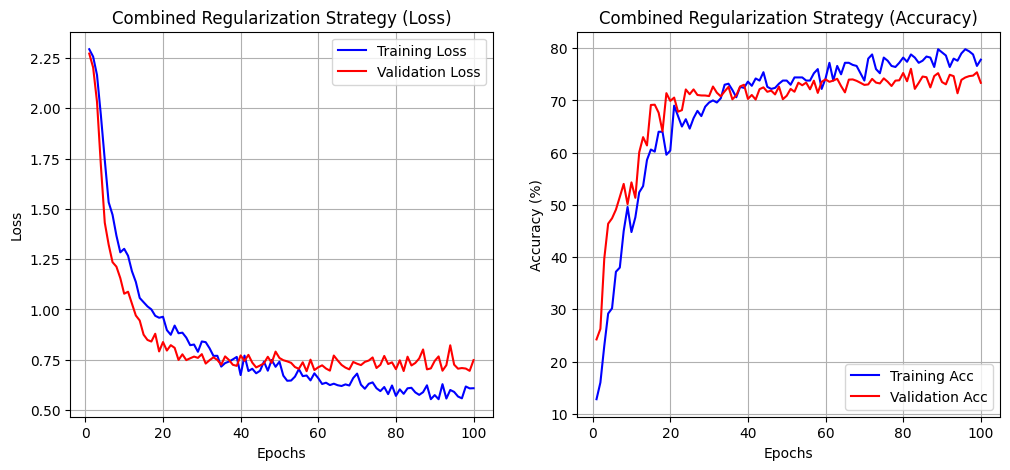

Final Validation Accuracy:
Baseline: 77.39%
Combined: 73.37%
Combined Gap: 4.43% (Should be the smallest gap)


In [8]:
print("Training Combined Model (Dropout + L2 + Augmentation)...")

# 1. Use the Augmented Loader
trainloader = trainloader_aug 

# 2. Initialize Model WITH Dropout
combo_model = OverfitMLP(dropout_rate=0.5)

# 3. Train with L2 Weight Decay
hist_combo = train_model(combo_model, weight_decay=0.01, epochs=100)

# 4. Compare Results
plot_curves(hist_combo, "Combined Regularization Strategy")

print(f"Final Validation Accuracy:")
print(f"Baseline: {hist_base[3][-1]:.2f}%")
print(f"Combined: {hist_combo[3][-1]:.2f}%")

gap_combo = hist_combo[2][-1] - hist_combo[3][-1]
print(f"Combined Gap: {gap_combo:.2f}% (Should be the smallest gap)")

### Conclusion

A combination of regularization techniques has brought out training and validation loss much closer to each other, but the final validation accuracy is somewhat smaller than the baseline. 

## Discussion 

Which is the better model? What else can we do to increase the final model's validation accuracy?